In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro
from pyro.contrib.gp.kernels import RBF, Linear, Constant, Periodic, Polynomial
from pyro.contrib.gp.models import GPRegression
from pyro.contrib.gp.kernels import Sum, Product
import pyro.distributions as dist
import random

/Users/christianjensen/Documents/probabilistic-machine-learning/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

In [3]:
def g(x):
    # defined on the domain x in [0,1]
    assert 0 <= x <= 1
    return -(np.sin(6*np.pi*x))**2 + 6*x**2 - 5*x**4 + 3/2

In [5]:
l=30

# Generating x values for train & test
X_grid = np.array([(i-1)/(l-1) for i in range(1,l+1)])

# Generating y values for train & test
mu, var = 0, 0.01
eps_grid = np.random.normal(loc = mu,  scale = np.sqrt(var), size = l)
y_grid = np.array([g(xi)+eps for xi, eps in zip(X_grid, eps_grid)])

In [6]:
all_indices = np.arange(30)
train_indices = np.sort(np.random.choice(all_indices, size=20, replace=False))
test_indices = np.setdiff1d(all_indices, train_indices)

# Splitting into train and test
X_train = torch.from_numpy(X_grid[train_indices]).to(torch.float32).reshape(-1,1) #[datapoints, features]
y_train = torch.from_numpy(y_grid[train_indices]).to(torch.float32) #[datapoints]

X_test = torch.from_numpy(X_grid[test_indices]).to(torch.float32).reshape(-1,1) #[datapoints, features] 
y_test = torch.from_numpy(y_grid[test_indices]).to(torch.float32) #[datapoints]


ValueError: 'y1' is not 1-dimensional

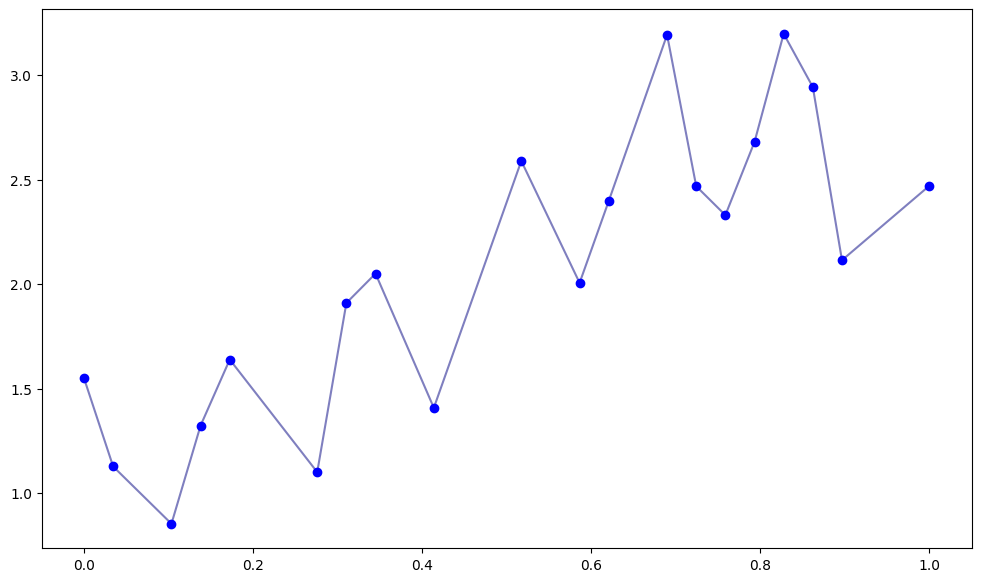

In [240]:

def sample_kernel_from_prior():

    #Periodic
    # periodic_amplitude = pyro.sample(f"periodic_amplitude",
    #     dist.LogNormal(torch.tensor(0.0), torch.tensor(0.2)))
    periodic_amplitude = torch.tensor(0.2)
    # period = pyro.sample(f"period",
    #     dist.LogNormal(torch.log(torch.tensor(1.0)), 0.2))
    period = torch.tensor(1/3)
    lengthscale = pyro.sample(f"lengthscale",
        dist.LogNormal(torch.tensor(-1.0), torch.tensor(0.25)))  # Changed from -5.0
    
    # Polynomial kernel parameters (for the new branch)
    # You can tune these distributions as you like
    poly_variance = pyro.sample(f"poly_variance",
        dist.LogNormal(torch.tensor(-0.5), torch.tensor(0.25)))
    poly_offset = pyro.sample(f"poly_offset",
        dist.LogNormal(torch.tensor(0.0), torch.tensor(0.25)))
    # You could make degree random too (or keep it fixed).
    poly_degree = 4

    # linear_variance = pyro.sample(f"linear_variance",
    #     dist.LogNormal(torch.tensor(0.0), torch.tensor(1)))

    linear_variance = torch.tensor(0)

    k1 = Periodic(input_dim=1, period=period,
                    variance=periodic_amplitude,
                    lengthscale=lengthscale)
    # k2 = Polynomial(input_dim=1,
    #                 variance=poly_variance,
    #                 bias=poly_offset,
    #                 degree=poly_degree)
    k2 = Linear(input_dim=1,variance=linear_variance)
    return Sum(k1, k2)


num_samples = 1
jitter_init=1e-4

pyro.clear_param_store()

x_visual = torch.linspace(0, 1, 100)
plt.figure(figsize=(12, 7))

plt.scatter(X_train, y_train, color='blue', zorder=5, label='Training data')
plt.plot(X_train, y_train, color='navy', alpha=0.5, zorder=4)

# Color schemes for all four kernel types
colors_periodic = plt.cm.Blues(np.linspace(0.3, 0.9, num_samples))
colors_full = plt.cm.Reds(np.linspace(0.3, 0.9, num_samples))
colors_rbf = plt.cm.Greens(np.linspace(0.3, 0.9, num_samples))
colors_all = plt.cm.Purples(np.linspace(0.3, 0.9, num_samples))  # New color scheme for all kernels

for i in range(num_samples):
    # Periodic
    kernel1 = sample_kernel_from_prior()  # note i=i
    # K1 = special_kernel(x_visual, x_visual, [3, 3])  # note i=i
    K1 = kernel1(x_visual, x_visual)
    K1.diagonal().add_(jitter_init)

    k_x_x = kernel1(X_train, X_train)
    k_x_xstar = kernel1(X_train, x_visual)
    k_xstar_xstar = kernel1(x_visual, x_visual)

    mustar = k_x_xstar.T @ torch.linalg.inv(k_x_x + torch.tensor(0.1)*torch.eye(len(y_train))) @ y_train
    sigmastar = k_xstar_xstar - k_x_xstar.T @ torch.linalg.inv(k_x_x + torch.tensor(0.1)*torch.eye(len(y_train))) @ k_x_xstar





    f1 = dist.MultivariateNormal(torch.zeros(len(x_visual)), K1).sample()
    print(x_visual.detach().numpy())
    print((mu - 2 * sigmastar).detach().numpy())
    plt.fill_between(x_visual.detach().numpy(), 
                    (mu - 2 * sigmastar).detach().numpy(), 
                    (mu + 2 * sigmastar).detach().numpy(), 
                    alpha=0.2, color=colors_periodic[i], zorder=2)
    # plt.plot(x_visual.numpy(), f1.numpy(), alpha=1, color=colors_periodic[i], 
    #             label=f"Periodic {i+1}", zorder=3)

plt.title('GP Prior Samples with Training Data')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

In [138]:
kernel1.shape

torch.Size([100, 100])

In [11]:
pyro.clear_param_store()
def plot_gp_samples(x_train, y_train, num_samples=1, jitter_init=1e-1):
    x_visual = torch.linspace(0, 1, 100)
    plt.figure(figsize=(12, 7))
    
    plt.scatter(x_train, y_train, color='blue', zorder=5, label='Training data')
    plt.plot(x_train, y_train, color='navy', alpha=0.5, zorder=4)
    
    # Color schemes for all four kernel types
    colors_periodic = plt.cm.Blues(np.linspace(0.3, 0.9, num_samples))
    colors_full = plt.cm.Reds(np.linspace(0.3, 0.9, num_samples))
    colors_rbf = plt.cm.Greens(np.linspace(0.3, 0.9, num_samples))
    colors_all = plt.cm.Purples(np.linspace(0.3, 0.9, num_samples))
    
    for i in range(num_samples):
        kernel2 = sample_kernel_from_prior("rbf_period")
        print(kernel2)
        # Compute kernel matrix
        K = kernel2(x_visual, x_visual)
        
        # Add jitter to diagonal before any operations
        K.diagonal().add_(jitter_init)
        
        # Ensure symmetry
        K = 0.5 * (K + K.T)
        
        # Add small RBF component for stability
        rbf_stabilizer = 1e-2 * torch.exp(-0.5 * torch.cdist(x_visual.unsqueeze(-1), x_visual.unsqueeze(-1))**2)
        K = K + rbf_stabilizer
        
        condition_number = torch.linalg.cond(K)
        print(f"Condition number: {condition_number}")
        print("iteration:", i)
    
        # Get and print parameters

        periodic_amplitude = kernel2.kern0.variance.item()
        period = kernel2.kern0.period.item()
        lengthscale = kernel2.kern0.lengthscale.item()

        variance_rbf = kernel2.kern1.variance.item()
        lengthscale_rbf = kernel2.kern1.lengthscale.item()
        print("here")
        print("\nSample parameter values:")

        print(f"Periodic amplitude: {periodic_amplitude:.3f}")
        print(f"Period: {period:.3f}")
        print(f"Lengthscale: {lengthscale:.3f}")
        print(f"variance_rbf : {variance_rbf}")
        print(f"lengthscalee_rbf : {lengthscale_rbf}")
        
        try:
            # Use Cholesky decomposition with better conditioning
            L = torch.linalg.cholesky(K)
            z = torch.randn(len(x_visual))
            f2 = torch.mv(L, z)
            
            plt.plot(x_visual.detach().numpy(), f2.detach().numpy(), alpha=1, color=colors_full[i], 
                    label=f"rbf_period {i+1}", zorder=3)
        except RuntimeError:
            print("Cholesky failed, adding more jitter")
            K.diagonal().add_(1e-1)  # Add more jitter if needed
            L = torch.linalg.cholesky(K)
            z = torch.randn(len(x_visual))
            f2 = torch.mv(L, z)
            plt.plot(x_visual.detach().numpy(), f2.detach().numpy(), alpha=1, color=colors_full[i], 
                    label=f"3term {i+1}", zorder=3)

    plt.title('GP Prior Samples with Training Data')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    return plt.gcf()

Product(
  (kern0): Periodic()
  (kern1): RBF()
)
Condition number: 576.640625
iteration: 0
here

Sample parameter values:
Periodic amplitude: 0.916
Period: 0.958
Lengthscale: 0.375
variance_rbf : 0.37242239713668823
lengthscalee_rbf : 0.5097452998161316


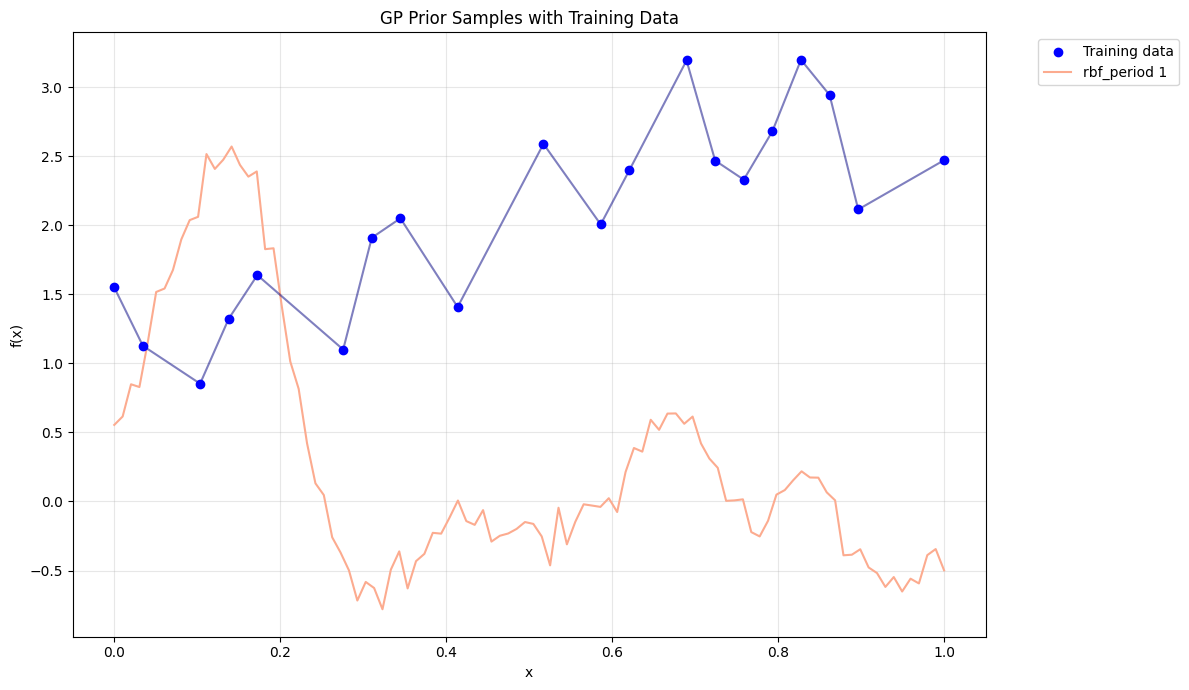

In [12]:
fig = plot_gp_samples(X_train, y_train, 1, 1e-2)